In [1]:
!pip install geemap

In [2]:
import hydrofunctions as hf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import folium
import geemap.foliumap as geemap
import ee
import matplotlib.dates as mdates
import hydrofns
import calendar
import pandas as pd

%matplotlib inline

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWiCNornfXYJu8WtmG4vc9LrzHtU10UHJ3zE1qD-ZwCYFFDJICzQvSU

Successfully saved authorization token.


In [4]:
# site number for NWIS gage (Pine Bluff AR Site)
pineBluff = ['07263650']

# Coordinates for site bounds at Pine Bluff AR
pineBluff_coord1 = [-91.75, 34.1845]
pineBluff_coord2 = [-92.1, 34.42]
pineBluff_coord3 = [-92.1973, 34.3831]
pineBluff_coord4 = [-91.83, 34.12]
pineBluff_coord5 = [-91.6933, 34.1845]

# Generate Pine Bluff site bounds geometry
pineBluff_rectangleGeoJSON = ee.Geometry.Polygon(
    [pineBluff_coord1, pineBluff_coord2, pineBluff_coord3,
        pineBluff_coord4, pineBluff_coord5]
)

pineBluff_bnds = ee.FeatureCollection(ee.Feature(pineBluff_rectangleGeoJSON,
        {'name': 'Pine Bluff, AR', 'fill': 1}))

# Palettes for visualizations
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
waterPalette = ['red', 'yellow', 'green', 'blue']

# Import the Sentinel 2 collection
sentinel2 = ee.ImageCollection(
    'COPERNICUS/S2_SR').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

In [5]:
# Define function for extracting water pixel count values from images
def get_water_pixel_count(bounds, start, end):
    """
    Generates water pixel count within provided site boundaries in GEE 
    compiled image. 

    Parameters
    ----------
    site : GEE FeatureCollection
        Site boundaries feature collection generated with GEE

    start : string
        Desired start date for image data

    end : string
        Desired end date for image data 

    Returns
    -------
    response_df : dataframe
        Dataframe created from downloaded csv    
    """
    
    ndwi_threshold = 0
    
    # Generate image from sentinel-2 data
    sentinel_image = sentinel2.filterBounds(
        bounds).filterDate(start, end).mosaic().clip(bounds)
    
    # Generate NDWI image and water map image
    ndwi_image = sentinel_image.normalizedDifference(['B3', 'B8'])
    water_pixel_image = ndwi_image.gt(ndwi_threshold).selfMask()

    # Extract water pixel count
    pixel_count_dict = water_pixel_image.reduceRegion(**{
        'reducer': ee.Reducer.count(),
        'geometry': bounds.geometry(),
        'scale': 10,
        'maxPixels': 1e9})
    pixel_count = pixel_count_dict.getInfo()

    return pixel_count

In [6]:
# Create list of start and end dates
monthly_starts = pd.date_range(start='2019-01-01', end='2019-12-31', freq='MS')
monthly_ends = pd.date_range(start='2019-01-01', end='2019-12-31', freq='M')
monthly_list = [monthly_starts.to_series(), monthly_ends.to_series()]
combined = pd.concat(monthly_list)
date_list = pd.DatetimeIndex(combined.values)

# Make date dictionary to loop through with get_water_pixel_count function
date_dict = {}
for n, date in enumerate(date_list):
    date_dict[n+1] = date

# Create list of pixel counts for each month of study period with function
list_pixels = []
for n, date in date_dict.items():
    if n < 13:
        monthly_pixel_count = get_water_pixel_count(
            pineBluff_bnds, date, date_dict[n+12])
        list_pixels.append(monthly_pixel_count)
    else:
        break

In [29]:
# Add pixel count values for each month to a dataframe
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
pb_water_pixel_df = pd.DataFrame(list_pixels, columns = ['nd'], index = months)

# Remove outliers due to cloud coverage
pb_water_pixel_df.iloc[6] = None

In [30]:
# Generate gage height dataframe for hydrofunctions data
pineBluff_gage_df = hydrofns.create_df_gageht(pineBluff, '2019-01-01', '2019-12-31')

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07263650&parameterCd=00065&startDT=2019-01-01&endDT=2019-12-31


In [31]:
# Combine monthly maximum gage values with pixel count values in single df
pineBluff_max_month_gage = pineBluff_gage_df.resample('M').max()
pineBluff_max_month_gage.index = months
pineBluff_max_month_gage['pixel_count'] = pb_water_pixel_df['nd']

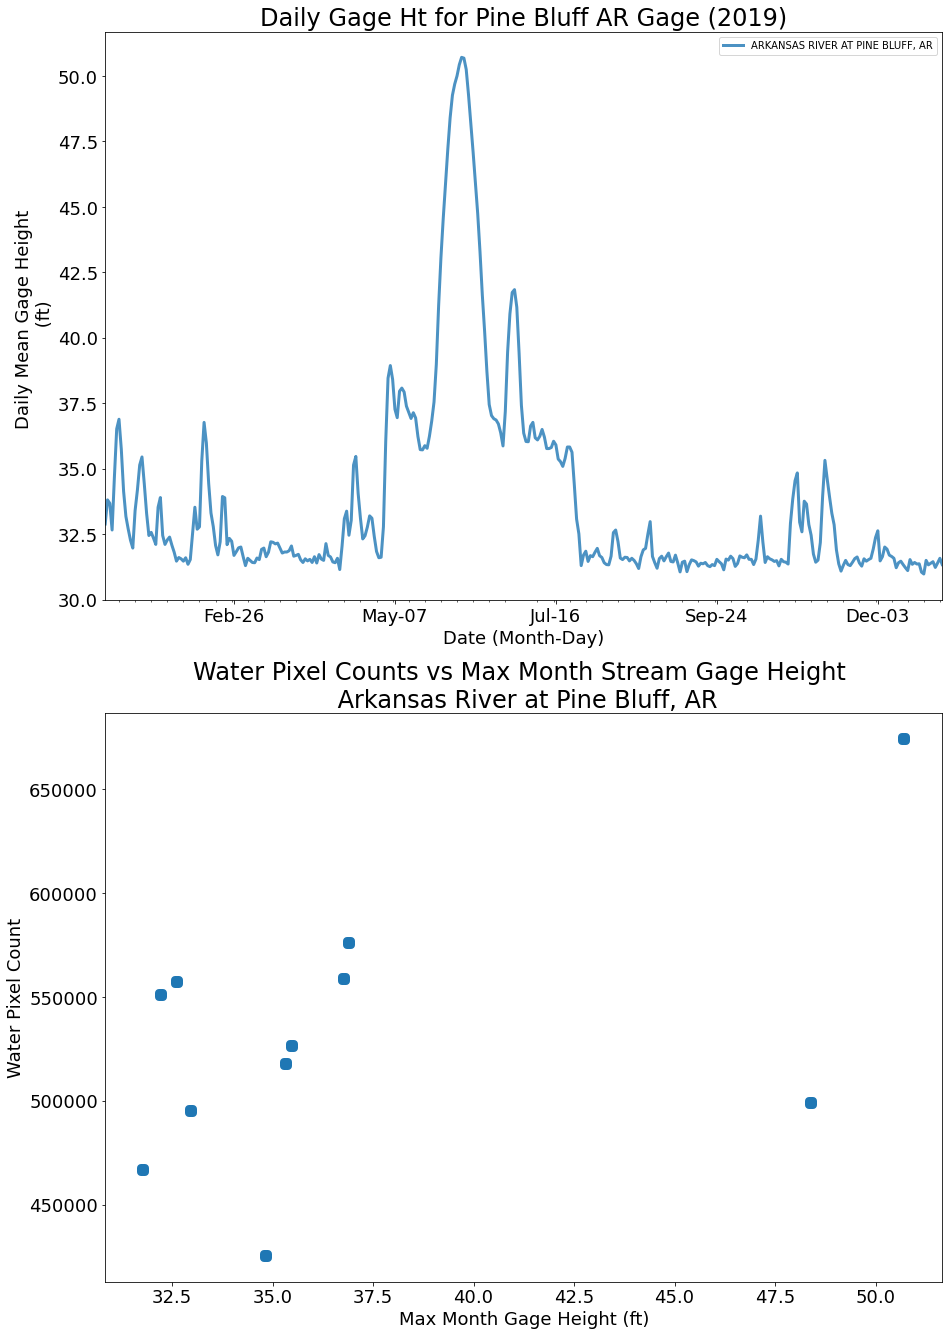

In [32]:
# Define plot space, overall size and title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 23))

# Create line plot for daily gage data at Pine Bluff
pineBluff_gage_df.plot(y='gage ht',
                       title="Daily Gage Ht for Pine Bluff AR Gage (2019)",
                       label='ARKANSAS RIVER AT PINE BLUFF, AR',
                       linewidth=3.0,
                       ax=ax1,
                       fontsize = 18,
                       alpha=.8)

# Create scatter plot for water pixel count vs max month gage data
pineBluff_max_month_gage.plot(kind='scatter',
                              x='gage ht',
                              y='pixel_count',
                              ax=ax2,
                              marker = ',',
                              linewidth=8.0,
                              fontsize=18,
                              title="Water Pixel Counts vs Max Month Stream Gage Height \n Arkansas River at Pine Bluff, AR")

# Define the date formats, set axis labels, font sizes
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Gage Height \n (ft)")
ax2.set(xlabel="Max Month Gage Height (ft)",
        ylabel="Water Pixel Count")
ax1.title.set_size(24)
ax2.title.set_size(24)
ax1.xaxis.label.set_size(18)
ax1.yaxis.label.set_size(18)
ax2.xaxis.label.set_size(18)
ax2.yaxis.label.set_size(18)

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})